In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AH5m1NP6DUwzrsOx3tfmX9ddQeS3VgShCYPsLWbCveFaIfOejx1WCU
Mounted at /content/drive


In [ ]:
!mkdir '/root/.kaggle/'
!echo '{"username":"","key":""}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
%cd '/content/drive/My Drive/Dicoding ML/transfer learning'
!ls

/content/drive/My Drive/Dicoding ML/transfer learning
apparel-images-dataset.zip  dataset_apparel	 model_dicoding_akhir.h5
apparel.ipynb		    dataset_experiments


In [ ]:
!kaggle datasets download -d trolukovich/apparel-images-dataset

100% 248M/248M [00:02<00:00, 101MB/s] 
100% 248M/248M [00:02<00:00, 87.5MB/s]


In [ ]:
!mkdir dataset_apparel
!unzip -q 'apparel-images-dataset.zip' -d dataset_apparel

In [ ]:
!mkdir dataset_experiments
!ls

apparel-images-dataset.zip  dataset_apparel	 model_dicoding_akhir.h5
apparel.ipynb		    dataset_experiments


In [28]:
exp_dir = 'dataset_experiments'
base_dir = 'dataset_apparel'
import re, shutil 
import os
from tqdm import tqdm 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201

In [ ]:
for folder in os.listdir(base_dir): 
    folder_path = os.path.join(base_dir, folder)
    class_dir = folder_path.split(os.sep)[1].split("_")[1]
    copy_dir = os.path.join(exp_dir, class_dir)
    if not os.path.isdir(copy_dir): os.mkdir(copy_dir)
    for img in tqdm(os.listdir(folder_path), position=0, leave=True):
        path_img = os.path.join(folder_path, img)
        shutil.copy2(path_img, copy_dir)

100%|██████████| 120/120 [00:59<00:00,  2.03it/s]


In [29]:
total_image = 0
image_count = {}
for class_ in os.listdir(exp_dir):
    class_dir = os.path.join(exp_dir, class_)
    img_len = len(os.listdir(class_dir))
    if class_ in image_count:
      image_count[class_] += img_len
    else:
      image_count[class_] = img_len

print("Total by Class:", image_count)

Total by Class: {'dress': 2570, 'pants': 2789, 'shirt': 1686, 'shoes': 3418, 'shorts': 922}


In [30]:
k_count = [k for k in image_count]
v_count = [image_count[k] for k in image_count]
total_all_images = np.sum(v_count)
print("Total seluruh gambar:", total_all_images)

Total seluruh gambar: 11385


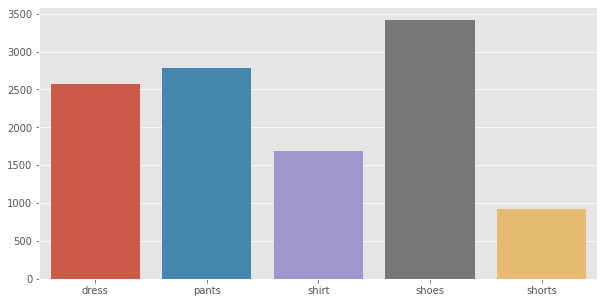

In [31]:
plt.figure(figsize=(10,5))
sns.barplot(k_count, v_count)
plt.show()

In [6]:
img_list = []
class_list = []

for class_ in os.listdir(exp_dir): 
    path_class = os.path.join(exp_dir, class_)
    for img in tqdm(os.listdir(path_class), position=0, leave=True):
        path_to_img = os.path.join(path_class, img)
        image = cv.imread(path_to_img)
        image = cv.resize(image, (128,128))
        img_list.append(image)
        class_list.append(class_)

100%|██████████| 922/922 [09:03<00:00,  1.70it/s]


In [7]:
assert len(img_list) == len(class_list)

In [11]:
x_img = np.array(img_list)
encoder = LabelBinarizer()
y_class = encoder.fit_transform(class_list)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(
    x_img, y_class, test_size = 0.2, shuffle=True, random_state = 42
    )

In [13]:

img_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, 
                                 vertical_flip = True,
                                 height_shift_range=0.1, width_shift_range=0.2,
                                 zoom_range=0.3, shear_range=0.1,
                                 rotation_range=90, fill_mode='nearest',
                                 validation_split = 0.2)
train_gen = img_datagen.flow(x_train, y_train, shuffle=True, seed=42)
val_gen = img_datagen.flow(x_train, y_train, subset='validation', shuffle=False, seed=42)

In [19]:
base_tf = DenseNet201(
    include_top=False, weights='imagenet', input_shape=(128,128,3)
    )
base_tf.trainable = False

74842112/74836368 [==============================] - 3s 0us/step


In [39]:
model = tf.keras.models.Sequential()
model.add(base_tf)
model.add(tf.keras.layers.Conv2D(1024, (2,2), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(2,2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 4, 4, 1920)        18321984  
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 1024)        7865344   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 1024)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)              

In [40]:
class Stopper(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.93 and logs.get('val_accuracy')>0.93):
      print("Stop training model got > 93% !!")
      self.model.stop_training = True

epoch = 50
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', 
    patience=10
    )

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model_dicoding_akhir.h5', monitor='accuracy', 
    verbose=1, save_best_only=True, mode='max'
    )
stopper = Stopper()

In [41]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )
history = model.fit(train_gen, 
          epochs=epoch,
          batch_size = 256,
          callbacks=[checkpoint,earlystop,stopper],
          validation_data=val_gen
          )

Epoch 1/50
285/285 [==============================] - ETA: 0s - loss: 0.9261 - accuracy: 0.7698
Epoch 00001: accuracy improved from -inf to 0.76976, saving model to model_dicoding_akhir.h5
285/285 [==============================] - 48s 169ms/step - loss: 0.9261 - accuracy: 0.7698 - val_loss: 0.4095 - val_accuracy: 0.8611
Epoch 2/50
285/285 [==============================] - ETA: 0s - loss: 0.4419 - accuracy: 0.8477
Epoch 00002: accuracy improved from 0.76976 to 0.84772, saving model to model_dicoding_akhir.h5
285/285 [==============================] - 45s 159ms/step - loss: 0.4419 - accuracy: 0.8477 - val_loss: 0.3439 - val_accuracy: 0.8792
Epoch 3/50
285/285 [==============================] - ETA: 0s - loss: 0.3830 - accuracy: 0.8706
Epoch 00003: accuracy improved from 0.84772 to 0.87055, saving model to model_dicoding_akhir.h5
285/285 [==============================] - 45s 158ms/step - loss: 0.3830 - accuracy: 0.8706 - val_loss: 0.3200 - val_accuracy: 0.8962
Epoch 4/50
285/285 [=====

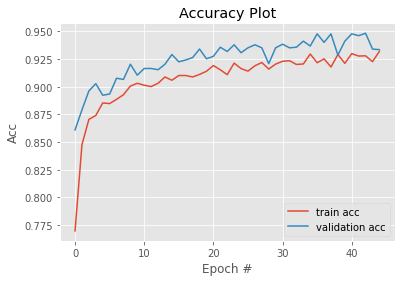

In [42]:
plt.style.use("ggplot")
plt.figure()
H = history
acc = H.history["accuracy"]
val_acc = H.history["val_accuracy"]
plt.plot(np.arange(0, len(acc)), acc, label="train acc")
plt.plot(np.arange(0, len(val_acc)), val_acc, label="validation acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

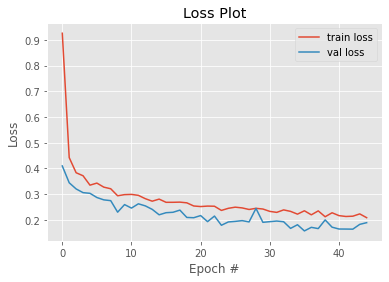

In [43]:
plt.style.use("ggplot")
plt.figure()
loss = H.history["loss"]
val_loss = H.history["val_loss"]
plt.plot(np.arange(0, len(loss)), loss, label="train loss")
plt.plot(np.arange(0, len(val_loss)), val_loss, label="val loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [44]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmppx778zfy/assets


INFO:tensorflow:Assets written to: /tmp/tmppx778zfy/assets


In [45]:
print("Evaluate on test data")
test_gen = ImageDataGenerator(rescale=1./255).flow(x_test, y_test)
results = model.evaluate(test_gen)
print("test loss, test acc:", results)

Evaluate on test data
72/72 [==============================] - 4s 53ms/step - loss: 0.1320 - accuracy: 0.9640
test loss, test acc: [0.13196547329425812, 0.9639877080917358]
